In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


dfWithDeath = pd.read_csv('heart_failure_clinical_records_dataset.csv')
dfWithDeath.dropna(inplace=True)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280


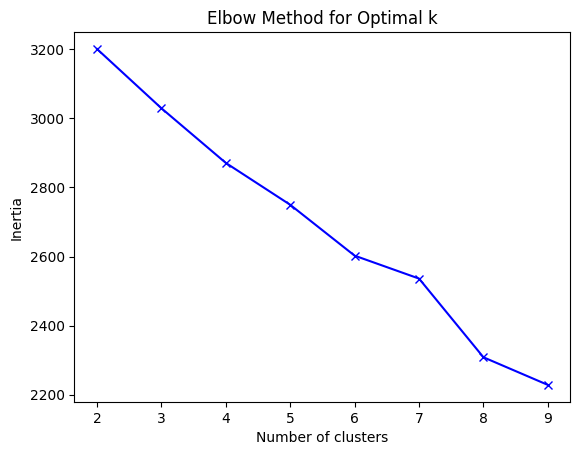

In [19]:
# Taking only a subset of features for clustering

df_subset_heart = df[['creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'serum_sodium','anaemia', 'diabetes', 'high_blood_pressure']].copy()
df_subset_demographic = df[['age', 'sex', 'smoking']].copy()
df_subset_condition = df[['anaemia', 'diabetes', 'high_blood_pressure']].copy()

df_subset = df  # Change this to try different subsets

# Scaling the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Elbow method to determine optimal k number of clusters

inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [20]:
# Set elbow based on the elbow plot
"""
subset of heart features -> elbow = 3
subset of demographic features -> elbow = 3
subset of condition features -> elbow = 2
"""
elbow = 8

# Fit KMeans with the chosen number of clusters

km = KMeans(n_clusters=elbow, random_state=0)
df_subset['cluster'] = km.fit_predict(df_subset)
summarexpected_output = df_subset.groupby('cluster').agg(['mean', 'std', 'count'])
summarexpected_output

age                    anaemia                  \
              mean        std count      mean       std count   
cluster                                                         
0        59.477273   9.744381    44  0.477273  0.505258    44   
1        60.105263  10.630882    38  0.526316  0.506009    38   
2        54.000000  15.588457     3  0.333333  0.577350     3   
3        61.340909  11.445911    88  0.318182  0.468440    88   
4        66.727273  14.367261    11  0.363636  0.504525    11   
5        63.444444  10.678379     9  0.444444  0.527046     9   
6        61.302227  12.953274    75  0.480000  0.502964    75   
7        58.892484  13.882147    31  0.483871  0.508001    31   

        creatinine_phosphokinase                     diabetes  ...  \
                            mean          std count      mean  ...   
cluster                                                        ...   
0                     603.386364   778.048191    44  0.477273  ...   
1                     441.263158   575.459754    38  0.315789  ...   
2                     893.333333  1010.523297     3  0.666667  ...   
3                     718.238636  1152.219657    88  0.420455  ...   
4                     328.909091   221.073497    11  0.636364  ...   
5                     875.222222   781.105431     9  0.444444  ...   
6                     455.573333   845.964381    75  0.413333  ...   
7                     616.290323  1425.813059    31  0.354839  ...   

        serum_sodium       sex                   smoking                  \
               count      mean       std count      mean       std count   
cluster                                                                    
0                 44  0.568182  0.501056    44  0.340909  0.479495    44   
1                 38  0.789474  0.413155    38  0.394737  0.495355    38   
2                  3  0.333333  0.577350     3  0.666667  0.577350     3   
3                 88  0.670455  0.472742    88  0.329545  0.472742    88   
4                 11  0.636364  0.504525    11  0.363636  0.504525    11   
5                  9  0.666667  0.500000     9  0.222222  0.440959     9   
6                 75  0.640000  0.483232    75  0.266667  0.445195    75   
7                 31  0.580645  0.501610    31  0.290323  0.461414    31   

               time                    
               mean         std count  
cluster                                
0        116.863636   72.707311    44  
1        128.421053   86.747110    38  
2        151.333333  109.696551     3  
3        132.750000   75.093237    88  
4        135.363636   88.287341    11  
5        147.222222   87.675221     9  
6        130.640000   72.869124    75  
7        134.774194   87.358537    31  

[8 rows x 36 columns]

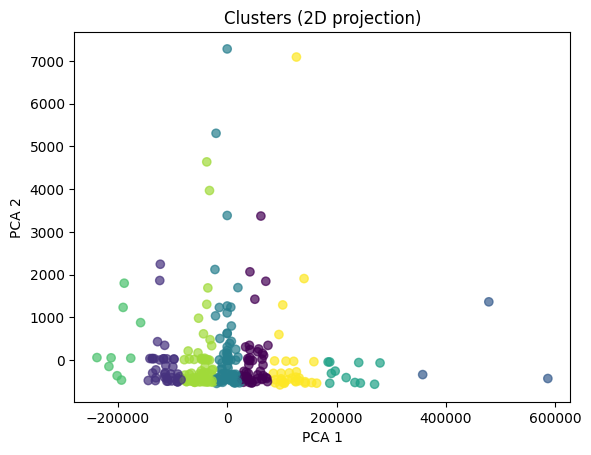

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_subset.drop(columns=['cluster']))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_subset["cluster"], cmap='viridis', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters (2D projection)')
plt.show()


In [22]:
"""
pvals = {}
for col in continuos_features:
    groups = [df.loc[df.cluster==k, col] for k in df.cluster.unique()]
    pvals[col] = stats.kruskal(*groups).pvalue

for col in categorical_features:
    contingency = pd.crosstab(df[col], df['cluster'])
    chi2, p, dof, ex = stats.chi2_contingency(contingency, correction=False)
    pvals[col] = p

# Multiple testing correction
_, pvals_fdr, _, _ = smm.multipletests(list(pvals.values()), method='fdr_bh')
pvals_corr = dict(zip(pvals.keys(), pvals_fdr))

print("\nCorrected p-values (FDR):")
print(pvals_corr)
"""


'\npvals = {}\nfor col in continuos_features:\n    groups = [df.loc[df.cluster==k, col] for k in df.cluster.unique()]\n    pvals[col] = stats.kruskal(*groups).pvalue\n\nfor col in categorical_features:\n    contingency = pd.crosstab(df[col], df[\'cluster\'])\n    chi2, p, dof, ex = stats.chi2_contingency(contingency, correction=False)\n    pvals[col] = p\n\n# Multiple testing correction\n_, pvals_fdr, _, _ = smm.multipletests(list(pvals.values()), method=\'fdr_bh\')\npvals_corr = dict(zip(pvals.keys(), pvals_fdr))\n\nprint("\nCorrected p-values (FDR):")\nprint(pvals_corr)\n'

In [ ]:
df_feats = df_subset.drop(columns='DEATH_EVENT')
expected_output = df_subset['DEATH_EVENT']
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(df_feats, expected_output)

perm = permutation_importance(rf, df_feats, expected_output, n_repeats=10, random_state=0)
importances = pd.Series(perm.importances_mean, index=df_feats.columns).sort_values(ascending=False)

print("\nPermutation Importances:")
print(importances)

KeyError: 'DEATH_EVENT'

In [24]:
"""
df_feats = df.drop(columns=['cluster', 'high_blood_pressure'])
expected_output = df['anaemia']
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(df_feats, expected_output)

perm = permutation_importance(rf, df_feats, expected_output, n_repeats=10, random_state=0)
importances = pd.Series(perm.importances_mean, index=df_feats.columns).sort_values(ascending=False)

print("\nPermutation Importances:")
print(importances)
"""


'\ndf_feats = df.drop(columns=[\'cluster\', \'high_blood_pressure\'])\nexpected_output = df[\'anaemia\']\nrf = RandomForestClassifier(n_estimators=200, random_state=0)\nrf.fit(df_feats, expected_output)\n\nperm = permutation_importance(rf, df_feats, expected_output, n_repeats=10, random_state=0)\nimportances = pd.Series(perm.importances_mean, index=df_feats.columns).sort_values(ascending=False)\n\nprint("\nPermutation Importances:")\nprint(importances)\n'

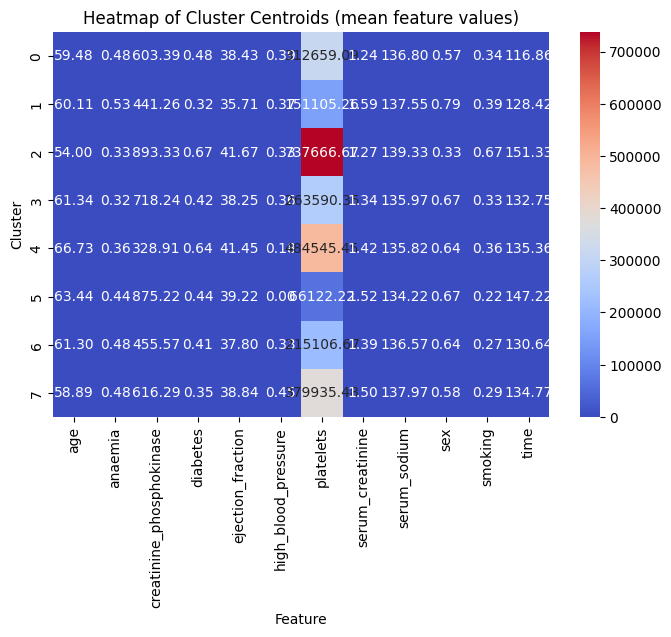

'# Boxplots for continuous variables\nfor col in continuos_features:\n    sns.boxplot(x=\'cluster\', y=col, data=df)\n    plt.title(f"{col.capitalize()} by cluster")\n    plt.show()\n\n# Barplots for binary features\nfor col in categorical_features:\n    sns.barplot(x=\'cluster\', y=col, data=df, estimator=np.mean)\n    plt.title(f"Proportion with {col} by cluster")\n    plt.show()'

In [25]:
plt.figure(figsize=(8,5))
cluster_means = df_subset.groupby('cluster').mean()
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title("Heatmap of Cluster Centroids (mean feature values)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.show()

"""# Boxplots for continuous variables
for col in continuos_features:
    sns.boxplot(x='cluster', y=col, data=df)
    plt.title(f"{col.capitalize()} by cluster")
    plt.show()

# Barplots for binary features
for col in categorical_features:
    sns.barplot(x='cluster', y=col, data=df, estimator=np.mean)
    plt.title(f"Proportion with {col} by cluster")
    plt.show()"""


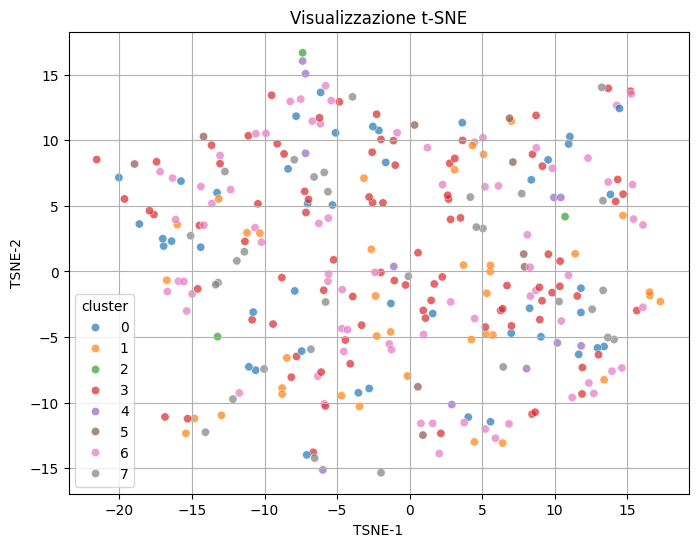

In [26]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Supponiamo tu abbia un DataFrame chiamato df
# Rimuoviamo eventuali colonne non numeriche (es. etichette)
df_numeric = df_subset.select_dtypes(include=['float64', 'int64'])

# Standardizzazione (molto importante per t-SNE)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Applichiamo t-SNE
tsne = TSNE(n_components=2, perplexity=30,random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

# Creiamo un nuovo DataFrame con i risultati
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE-1', 'TSNE-2'])

# Visualizzazione
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df_tsne['TSNE-1'], 
    y=df_tsne['TSNE-2'], 
    hue=df_subset['cluster'],  # questa Ã¨ la chiave!
    palette='tab10',  # puoi cambiare palette
    alpha=0.7
)
plt.title('Visualizzazione t-SNE')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.grid(True)